# Double DK rumour spreading model


### Setup guide

This model uses [graph-tool](https://graph-tool.skewed.de/) to efficiently support graph drawing at scale (~4000 nodes). [Unfortunately, graph tool does not support being installed through pip.](https://graph-tool.skewed.de/installation.html#native-installation)

To run this model, use the following instructions:

1. Install your python environment manager. If you don't have one, we recommend installing micromamba.
2. Set up your environment by running `micromamba env create --name compmodelling-dk -c conda-forge networkx graph-tool ipykernel`. If using conda or mamba, swap out 'micromamba' for the respective environment manager name.
3. Make sure your software reading this .ipynb file is using your compmodelling-dk python version. (Hint: use `which python` while in your environment to see where your python version is located). You may need to reload during this step for your software to recognise the environment.
4. When you're finished with your environment, remove it by running `micromamba env remove compmodelling-dk`.


### Constants

This code block contains:
- Imports required for the model to run
- Enum setup
- Initial constant configurations for the model

In [125]:
import os
import time
from enum import Enum
from typing import Self

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from graph_tool.all import (
    Graph,
    closeness,
    graph_draw,
    sfdp_layout,
)
from IPython.display import HTML, clear_output

# States people can be in
class State(Enum):
    # People who haven't encountered either the rumour or the truth
    IGNORANT = 0

    # People actively spreading their belief
    SPREADER = 1

    # People who have a belief but are not spreading it
    CONTAINER = 2

# Beliefs people can have
class Belief(Enum):
    RUMOUR = 0
    TRUTH = 1

# Mapping of states and beliefs to colours
COLOURS = {
    (None, State.IGNORANT): 'blue',
    (Belief.RUMOUR, State.SPREADER): 'orange',
    (Belief.RUMOUR, State.CONTAINER): 'red',
    (Belief.TRUTH, State.SPREADER): 'darkgreen',
    (Belief.TRUTH, State.CONTAINER): 'lawngreen'
}

# Mapping of states and beliefs to labels
LABELS = {
    (None, State.IGNORANT): 'Ignorant',
    (Belief.RUMOUR, State.SPREADER): 'Rumour spreader',
    (Belief.RUMOUR, State.CONTAINER): 'Rumour container',
    (Belief.TRUTH, State.SPREADER): 'Truth spreader',
    (Belief.TRUTH, State.CONTAINER): 'Truth container'
}

# Simulation parameters
TIME_STEPS = 25

# Graph parameters used to generate the BA graph
POPULATION_SIZE = 4039
CLUSTERING_COEFFICIENT = 44

# Agent parameters for rumour and truth spreading
ACTIVENESS = 0.1
RUMOUR_ACCEPTANCE_PROB = 0.4
TRUTH_ACCEPTANCE_PROB = 0.7
LOSE_INTEREST_PROB = 0.1

# Controller connection strategies
class ControllerConnectionStrategies(Enum):
    RANDOM = 0
    COMMUNITIES = 1

# Controller attributes
CONTROLLER_CREDIBILITY = 0.7
CONTROLLER_DELAY = 2

# Controller connection strategy parameters
CONTROLLER_CONNECTION_STRATEGIES = ControllerConnectionStrategies.COMMUNITIES
CCS_RANDOM_NODES = 50 # Only used for random strategy
CCS_COMMUNITIES_NUM = 3 # Only used for communities strategy
CCS_COMMUNITIES_SIZE = 20 # Only used for communities strategy

### Person

This code block contains the definition for the Person class. This the agent that this Agent-based model explores- one is created for each node in the supplied graph.

In [126]:
class Person:
    """Class representing a person (agent) in the network."""

    def __init__(self: Self) -> None:
        """Constructor for the Person class."""
        self.belief = None
        self.state = State.IGNORANT

        self.credibility = np.clip(np.random.normal(0.5, 0.1), 0, 1) # Mean of 0.5, std dev of 0.1, restricted to [0, 1]
        self.conviction = 0.1

        self.contacted = set()

    def contact(self: Self, neighbour: list) -> None:
        """Contact another person and potentially spread beliefs.
        
        Args:
            neighbour: The person to contact.
        """
        # Checks the nodes are active and haven't already contacted each other
        if neighbour in self.contacted or np.random.random() > ACTIVENESS:
            return

        # Add each other to the contacted list so they don't contact each other again this time step
        self.contacted.add(neighbour)
        neighbour.contacted.add(self)

        # If neighbour doesn't have same belief (ignorant or opposite belief)
        if self.belief != neighbour.belief:
            # Try to convince neighbour
            could_persuade = self.persuade_check(neighbour)

            # If neighbour has the opposite belief while not convinced, they will try to convince back
            if (neighbour.belief is not None) and (not could_persuade):
                neighbour.persuade_check(self)
        # If neighbour has the same belief
        else:
            # Both increase their conviction in the belief
            self.conviction += (1 - self.conviction) * neighbour.credibility
            neighbour.conviction += (1 - neighbour.conviction) * self.credibility

            # Might lose interest in spreading more
            self.lose_interest_check()
            if neighbour.state == State.SPREADER:
                neighbour.lose_interest_check()

    def persuade_check(self: Self, neighbour: list) -> bool:
        """Check if the person can persuade the neighbour to change their belief.
        
        Args:
            neighbour: The person to potentially persuade.
            
        Returns:
            True if the person successfully persuaded the neighbour, False otherwise.
        """
        info_believability = RUMOUR_ACCEPTANCE_PROB if self.belief == Belief.RUMOUR else TRUTH_ACCEPTANCE_PROB

        convincing_power = self.credibility * info_believability
        resistance = neighbour.conviction
        conversion_prob = convincing_power / (convincing_power + resistance)

        if np.random.random() < conversion_prob:
            neighbour.belief = self.belief
            neighbour.state = self.state
            neighbour.conviction = conversion_prob
            return True
        return False

    def lose_interest_check(self: Self) -> None:
        """Check if the person loses interest in spreading the belief."""
        if np.random.random() < LOSE_INTEREST_PROB and not self.conviction == 1:
            self.state = State.CONTAINER

    def next(self: Self) -> None:
        """Move to the next time step."""
        self.contacted = set()

    def make_controller(self: Self, credibility: float) -> None:
        """Make the person a controller.
        
        Args:
            credibility: The credibility of the controller.
        """
        self.belief = Belief.TRUTH
        self.state = State.SPREADER
        self.credibility = credibility
        self.conviction = 1

    def make_rumour_starter(self: Self) -> None:
        """Make the person a rumour starter."""
        self.belief = Belief.RUMOUR
        self.state = State.SPREADER


### DKModel

This code block contains the definition for the DKModel class. This is the environment that contains agents (people) and their connections.

In [127]:
class DKModel:
    """Class representing the modified Deffuant-Kirman model."""

    def __init__(self: Self, nx_graph: nx.Graph, initial_rumour_spreaders: int, initial_truth_spreaders: int) -> None:
        """Constructor for the DKModel class.
        
        Args:
            nx_graph: The NetworkX graph to use for the simulation.
            initial_rumour_spreaders: The number of people to start spreading the rumour.
            initial_truth_spreaders: The number of people to start spreading the truth.
        """
        # Setup graphs
        self.nx_graph = nx_graph
        self.graph = Graph(directed=False)
        self.graph.add_edge_list(self.nx_graph.edges)

        # Setup vertex properties
        self.colours = self.graph.new_vp("string")
        self.graph.vertex_properties['agent'] = self.graph.new_vertex_property('object')

        for vertex in self.graph.vertices():
            self.graph.vertex_properties['agent'][vertex] = Person()

        # Setup initial states
        rumour_starters = np.random.choice(list(self.graph.vertices()), initial_rumour_spreaders, replace=False)
        for vertex in rumour_starters:
            self.graph.vertex_properties['agent'][vertex].make_rumour_starter()

        self.initial_truth_spreaders = initial_truth_spreaders

        # History tracking
        self.history = {
            (None, State.IGNORANT): [],
            (Belief.RUMOUR, State.SPREADER): [],
            (Belief.RUMOUR, State.CONTAINER): [],
            (Belief.TRUTH, State.SPREADER): [],
            (Belief.TRUTH, State.CONTAINER): []
        }
        self.timestamp = None

        # Cached graph drawing details
        self.pos = sfdp_layout(self.graph)
        self.vertex_order = closeness(self.graph)

        # Compute colours for first draw
        for vertex in self.graph.vertices():
            agent = self.graph.vertex_properties['agent'][vertex]
            self.colours[vertex] = COLOURS[(agent.belief, agent.state)]

    def add_node_with_random_neighbours(self: Self, neighbour_count: int, person: Person) -> None:
        """Adds a node to the graph(s) with a random number of neighbours.
        
        Args:
            neighbour_count: The number of neighbours to add.
            person: The person to add to the graph.
        """
        # Choose random neighbours
        neighbours = np.random.choice(list(self.graph.vertices()), neighbour_count, replace=False)

        # Add vertex to gt graph
        new_vertex = self.graph.add_vertex()
        self.graph.vertex_properties['agent'][new_vertex] = person

        # Add vertex to nx graph
        self.nx_graph.add_node(self.graph.vertex_index[new_vertex])

        # Connect the new node to its neighbours
        for neighbour in neighbours:
            # Add edge to gt graph
            self.graph.add_edge(new_vertex, neighbour)

            # Add edge to nx graph
            self.nx_graph.add_edge(self.graph.vertex_index[neighbour], self.graph.vertex_index[new_vertex])

    def add_node_with_random_communities(self: Self, community_count: int, people_per_community: int, person: Person) -> None:
        """Adds a node to the graph(s) with a random number of neighbours from limited random communities.
        
        Args:
            community_count: The number of communities to choose from.
            people_per_community: The number of people to choose from each community.
            person: The person to add to the graph.
        """
        new_node_index = self.graph.num_vertices()

        # Choose random communities
        communities = nx.community.louvain_communities(self.nx_graph)
        available_communities = [community for community in communities if len(community) >= people_per_community]
        chosen_communities = np.random.choice(available_communities, community_count, replace=False)

        # Add vertex to nx graph
        self.nx_graph.add_node(new_node_index)

        # Add vertex to gt graph
        new_vertex = self.graph.add_vertex()
        self.graph.vertex_properties['agent'][new_vertex] = person

        # Choose random nodes from each community
        for community_nodes in chosen_communities:
            chosen_nodes = np.random.choice(list(community_nodes), people_per_community, replace=False)

            for node in chosen_nodes:
                # Add edge to nx graph
                self.nx_graph.add_edge(new_node_index, node)

                # Add edge to gt graph
                self.graph.add_edge(new_vertex, self.graph.vertex(node))

    def step(self: Self) -> None:
        """Runs a single step of the simulation."""
        # Contact each neighbour and try to spread belief
        for vertex in self.graph.vertices():
            agent = self.graph.vertex_properties['agent'][vertex]

            for neighbour in self.graph.vertex(vertex).all_neighbours():
                if agent.state != State.SPREADER:
                    break
                agent.contact(self.graph.vertex_properties['agent'][neighbour])

        # Prepare for graphing and agent next steps
        counters = {
            (None, State.IGNORANT): 0,
            (Belief.RUMOUR, State.SPREADER): 0,
            (Belief.RUMOUR, State.CONTAINER): 0,
            (Belief.TRUTH, State.SPREADER): 0,
            (Belief.TRUTH, State.CONTAINER): 0
        }

        for vertex in self.graph.vertices():
            # Clear agent contact history
            agent = self.graph.vertex_properties['agent'][vertex]
            agent.next()

            # Add to state count
            counters[(agent.belief, agent.state)] += 1

            # Update node colour
            self.colours[vertex] = COLOURS[(agent.belief, agent.state)]

        for key, count in counters.items():
            self.history[key].append(count)

    def draw(self: Self) -> None:
        """Draws the current state of the simulation."""
        # Delete previous images
        if self.timestamp is not None:
            os.remove(f"graph{self.timestamp}.png")
            os.remove(f"count{self.timestamp}.png")

        # Append timestamp to filenames to avoid caching
        self.timestamp = time.time()

        graph_draw(self.graph,
                   vertex_fill_color=self.colours,
                   pos=self.pos,
                   vertex_order=self.vertex_order,
                   output=f"graph{self.timestamp}.png")

        # Draw counts of each state
        plt.figure(figsize=(10, 6))

        labels = list(LABELS.values())

        values = []
        if len(self.history[(None, State.IGNORANT)]) == 0: # No history yet
            values = [0, 0, 0, 0, 0]
        else:
            values = [self.history[(belief, state)][-1] for (belief, state) in LABELS.keys()]

        colours = [COLOURS[(belief, state)] for (belief, state) in LABELS.keys()]

        plt.barh(labels[::-1], values[::-1], color=colours[::-1])
        plt.tight_layout()
        plt.xticks(range(0, POPULATION_SIZE + 1, 500))
        plt.savefig(f"count{self.timestamp}.png")
        plt.close()

        # Display the images
        html = f"""
        <div style="display: flex;">
            <img src="graph{self.timestamp}.png" style="height: 500px">
            <img src="count{self.timestamp}.png" style="height: 500px">
        </div>"""
        display(HTML(html))

    def run(self: Self, time_steps: int, draw=False) -> None:
        """Runs the simulation for a given number of time steps."""
        for _ in range(time_steps):
            if draw:
                self.draw()

            if _ == CONTROLLER_DELAY:
                # Setup initial truth spreaders
                for _ in range(self.initial_truth_spreaders):
                    new_controller = Person()
                    new_controller.make_controller(credibility=CONTROLLER_CREDIBILITY)
                    if CONTROLLER_CONNECTION_STRATEGIES == ControllerConnectionStrategies.RANDOM:
                        self.add_node_with_random_neighbours(CCS_RANDOM_NODES, person=new_controller)
                    elif CONTROLLER_CONNECTION_STRATEGIES == ControllerConnectionStrategies.COMMUNITIES:
                        self.add_node_with_random_communities(community_count=3, people_per_community=20, person=new_controller)

            self.step()
            if draw:
                clear_output(wait=True)
        if draw:
            self.draw()

### Visualisation and Analysis 1

This code block contains the code to run the model with visualisation enabled. It also prints a line graph tracking the history of the system after the model is finished running.

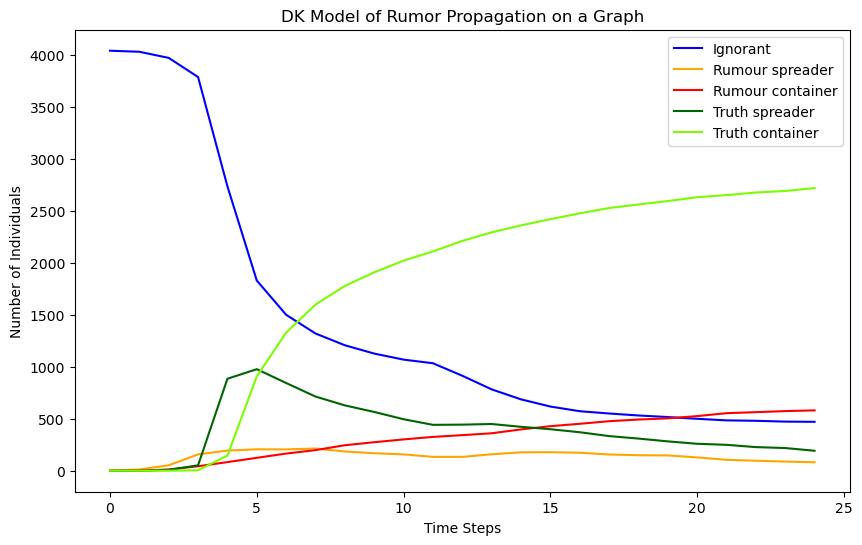

In [128]:
# Change the commenting of the code here to change what graph is used
# nx_graph = nx.barabasi_albert_graph(POPULATION_SIZE, CLUSTERING_COEFFICIENT)
nx_graph = nx.read_edgelist('datasets/facebook_combined.txt')

# Run the DK model
dk_model = DKModel(nx_graph, initial_rumour_spreaders=1, initial_truth_spreaders=1)
dk_model.run(TIME_STEPS, draw=True)

# Plot the history of the simulation
plt.figure(figsize=(10, 6))

for (belief, state) in LABELS.keys():
    plt.plot(dk_model.history[(belief, state)], label=LABELS[(belief, state)], color=COLOURS[(belief, state)])

plt.title('DK Model of Rumor Propagation on a Graph')
plt.xlabel('Time Steps')
plt.ylabel('Number of Individuals')
plt.legend()
plt.show()



### Analysis 2

This analysis runs four different strategies for rumour rebuttal with different credibilities, and determines through multiple trials which strategy is the most effective.

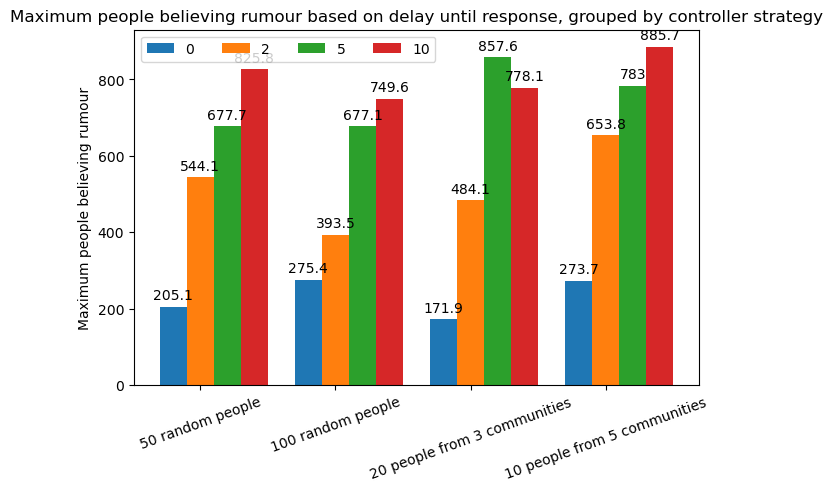

In [134]:
# Run the DK model with different controller connection strategies
TRIALS = 10
TIME_STEPS = 25
CONTROLLER_DELAY_VALUES = [0, 2, 5, 10]

def setup_ccs(ccs: ControllerConnectionStrategies, ccs_random_nodes: int = None, ccs_communities_num: int = None, ccs_communities_size: int = None) -> None:
    """Setup the controller connection strategy.
    
    Args:
        ccs: The controller connection strategy to use.
        ccs_random_nodes: The number of random nodes to use for the random strategy.
        ccs_communities_num: The number of communities to use for the communities strategy.
        ccs_communities_size: The number of people per community to use for the communities strategy.
    """
    global CONTROLLER_CONNECTION_STRATEGIES, CCS_RANDOM_NODES, CCS_COMMUNITIES_SIZE, CCS_COMMUNITIES_NUM
    CONTROLLER_CONNECTION_STRATEGIES = ccs
    CCS_RANDOM_NODES = ccs_random_nodes
    CCS_COMMUNITIES_NUM = ccs_communities_num
    CCS_COMMUNITIES_SIZE = ccs_communities_size

# Setup the controller connection strategies
CCS_SETUP_FUNCTIONS = {
    "50 random people": lambda: setup_ccs(ControllerConnectionStrategies.RANDOM, ccs_random_nodes=50),
    "100 random people": lambda: setup_ccs(ControllerConnectionStrategies.RANDOM, ccs_random_nodes=100),
    "20 people from 3 communities": lambda: setup_ccs(ControllerConnectionStrategies.COMMUNITIES, ccs_communities_num=3, ccs_communities_size=20),
    "10 people from 5 communities": lambda: setup_ccs(ControllerConnectionStrategies.COMMUNITIES, ccs_communities_num=5, ccs_communities_size=10)
}

# Run the DK model with different controller connection strategies
controller_delays = {}
for controller_delay_value in CONTROLLER_DELAY_VALUES:
    controller_delays[str(controller_delay_value)] = []
    CONTROLLER_DELAY = controller_delay_value
    for setup_name, setup_function in CCS_SETUP_FUNCTIONS.items():
        setup_function()

        # For a delay and setup, run the model multiple times and record the average maximum rumour size
        max_rumour_size = []
        for _ in range(TRIALS):
            # nx_graph = nx.barabasi_albert_graph(POPULATION_SIZE, CLUSTERING_COEFFICIENT)
            nx_graph = nx.read_edgelist('datasets/facebook_combined.txt')
            dk_model = DKModel(nx_graph, initial_rumour_spreaders=1, initial_truth_spreaders=1)
            dk_model.run(TIME_STEPS)
            max_rumour_size.append(max(dk_model.history[(Belief.RUMOUR, State.SPREADER)]))

        average_max_rumour_size = np.mean(max_rumour_size)
        controller_delays[str(controller_delay_value)].append(average_max_rumour_size)

# Plot the results into a grouped bar chart
x = np.arange(len(CCS_SETUP_FUNCTIONS))
width = 1 / (len(CCS_SETUP_FUNCTIONS) + 1)

fig, ax = plt.subplots(layout='constrained')

# Create bars for each delay
for index, (controller_delay_value, rumour_sizes) in enumerate(controller_delays.items()):
    offset = width * index
    rects = ax.bar(x + offset, rumour_sizes, width, label=controller_delay_value)
    ax.bar_label(rects, padding=3)

# Set up the plot
ax.set_ylabel('Maximum people believing rumour')
ax.set_title('Maximum people believing rumour based on delay until response, grouped by controller strategy')
ax.set_xticks(x + width, CCS_SETUP_FUNCTIONS.keys(), rotation=20)
ax.legend(loc='upper left', ncols=4)

plt.show()

### Analysis 3

This analysis runs the top two strategies determined in the analysis 2, and further evaluates their performance over a larger number of trials.

In [ ]:
# Setup variables for the final and max rumour/truth sizes
TRIALS = 10
final_rumour_sizes = []
final_truth_sizes = []
max_rumour_sizes = []
max_truth_sizes = []

# Run the model multiple times and record the final and max rumour/truth sizes
for _ in range(TRIALS):
    dk_model = DKModel(nx_graph, initial_rumour_spreaders=1, initial_truth_spreaders=1)
    dk_model.run(TIME_STEPS)

    final_rumour_sizes.append(dk_model.history[(Belief.RUMOUR, State.SPREADER)][-1] + dk_model.history[(Belief.RUMOUR, State.CONTAINER)][-1])
    final_truth_sizes.append(dk_model.history[(Belief.TRUTH, State.SPREADER)][-1] + dk_model.history[(Belief.TRUTH, State.CONTAINER)][-1])
    max_rumour_sizes.append(max(dk_model.history[(Belief.RUMOUR, State.SPREADER)] + dk_model.history[(Belief.RUMOUR, State.CONTAINER)]))
    max_truth_sizes.append(max(dk_model.history[(Belief.TRUTH, State.SPREADER)] + dk_model.history[(Belief.TRUTH, State.CONTAINER)]))

def display_histogram(data: list, title: str) -> None:
    """Display a histogram of the given data.
    
    Args:
        data: The data to display.
        title: The title of the histogram.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=20, edgecolor='black')
    plt.title(title)
    plt.xlabel('Number of Individuals')
    plt.ylabel('Frequency')
    plt.show()

# Display histograms of the final and max rumour/truth sizes
display_histogram(final_rumour_sizes, 'Final Rumour Sizes')
display_histogram(final_truth_sizes, 'Final Truth Sizes')
display_histogram(max_rumour_sizes, 'Max Rumour Sizes')
display_histogram(max_truth_sizes, 'Max Truth Sizes')